# Demo - White Box Attack (Imagenet)

In [51]:
import numpy as np
import json
import os
import sys
import time
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torchattacks

from utils import imshow, image_folder_custom_label

In [52]:
print("PyTorch", torch.__version__)
print("Torchvision", torchvision.__version__)
print("Torchattacks", torchattacks.__version__)
print("Numpy", np.__version__)

PyTorch 1.9.1+cu102
Torchvision 0.10.1+cu102
Torchattacks 3.1.0
Numpy 1.21.2


## 1. Load Data

In [53]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [54]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    
# Using normalization for Inception v3.
# https://discuss.pytorch.org/t/how-to-preprocess-input-for-pre-trained-networks/683
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],                     
#                          std=[0.229, 0.224, 0.225])
    
# However, DO NOT USE normalization transforms here.
# Torchattacks only supports images with a range between 0 and 1.
# Thus, please refer to the model construction section.
    
])

In [55]:
imagnet_data = image_folder_custom_label(root='./data/imagenet', transform=transform, idx2label=idx2label)
data_loader = torch.utils.data.DataLoader(imagnet_data, batch_size=1, shuffle=False)

True Image & True Label


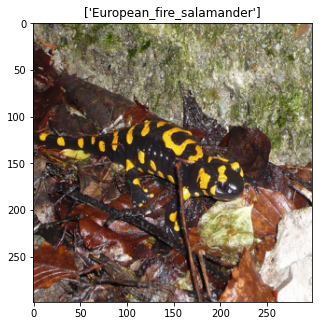

In [56]:
images, labels = iter(data_loader).next()

print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True, nrow = 10), [imagnet_data.classes[i] for i in labels])

## 2. Load Inception v3

In [57]:
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [58]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [59]:
import ipywidgets
# Adding a normalization layer for Resnet18.
# We can't use torch.transforms because it supports only non-batch images.
norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model = nn.Sequential(
    norm_layer,
    #models.wide_resnet50_2(pretrained=True)
    models.resnet18(pretrained=True)
).to(device)

model = model.eval()

In [61]:
# from torchviz import make_dot
# from torch.autograd import Variable

# # Variable을 통하여 Input 생성
# x = Variable(torch.randn(1, 8)) 

# # 앞에서 생성한 model에 Input을 x로 입력한 뒤 (model(x))  graph.png 로 이미지를 출력합니다.
# make_dot(model(x), params=dict(model.named_parameters())).render("graph", format="png")

## 3. Adversarial Attack

In [62]:
from torchattacks import *

In [63]:
atks = [
    FGSM(model, eps=8/255),
    #BIM(model, eps=8/255, alpha=2/255, steps=100),
    #RFGSM(model, eps=8/255, alpha=2/255, steps=100),
    CW(model, c=1, lr=0.01, steps=100, kappa=0),
    # PGD(model, eps=8/255, alpha=2/225, steps=100, random_start=True),
    #PGDL2(model, eps=1, alpha=0.2, steps=100),
    #EOTPGD(model, eps=8/255, alpha=2/255, steps=100, eot_iter=2),
    # FFGSM(model, eps=8/255, alpha=10/255),
    # TPGD(model, eps=8/255, alpha=2/255, steps=100),
    # MIFGSM(model, eps=8/255, alpha=2/255, steps=100, decay=0.1),
    # VANILA(model),
    # GN(model, sigma=0.1),
    # APGD(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='ce'),
    # APGD(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='dlr'),
    # APGDT(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1),
    # FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=False),
    # FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=True),
    # Square(model, eps=8/255, n_queries=5000, n_restarts=1, loss='ce'),
    AutoAttack(model, eps=8/255, n_classes=10, version='standard'),
    # OnePixel(model, pixels=5, inf_batch=50),
    # DeepFool(model, steps=100),
    # DIFGSM(model, eps=8/255, alpha=2/255, steps=100, diversity_prob=0.5, resize_rate=0.9)
]

In [64]:
print("Adversarial Image & Predicted Label")

for atk in atks :
    
    print("-"*70)
    print(atk)
    
    correct = 0
    total = 0
    
    for images, labels in data_loader: # batch로 나눠서 돌리는듯.
        # images : torch.Size([1,3,299,299])
        # labels: torch.Size([10]),[7, 5, 388, 1, ...] -> cock, electric_ray, giant_panda...
        
        start = time.time()
        adv_images = atk(images, labels)
        labels = labels.to(device)
        outputs = model(adv_images) # outputs: torch.Size([10, 1000]), adversarial image를 모델에 넣은 결과

        _, pre = torch.max(outputs.data, 1) # pre: torch.Size([10]), 왜 max해주는지 모르겟음!! 아마 shape을 바꾸려고?? _가 value이고 pre가 label이라 label만 남는 듯.

        total += len(images)
        correct += (pre == labels).sum()
        for i in range(len(pre)):
            if pre[i] == labels[i]:
                print("같다!!!!!!!!!!!!")
                print(labels[i])
        print("정답:", end="")
        print([imagnet_data.classes[i] for i in labels])
        print("예측:", end="")
        print([imagnet_data.classes[j] for j in pre])
        imshow(img=torchvision.utils.make_grid(adv_images.cpu().data, normalize=True, nrow = 10), title=None)
        imshow(img=torchvision.utils.make_grid(images, normalize=True, nrow = 10), title=None)
    print('Total elapsed time (sec): %.2f' % (time.time() - start))
    print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))

Adversarial Image & Predicted Label
----------------------------------------------------------------------
FGSM(model_name=Sequential, device=cuda:0, eps=0.03137254901960784, attack_mode=default, return_type=float)


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 7.93 GiB total capacity; 6.45 GiB already allocated; 24.62 MiB free; 7.01 GiB reserved in total by PyTorch)